In [1]:
path_main_summarized_table = "../datasets/2023-01-01_benchmark_processed_data/2023-01-27_FullTableAurocFiltered.tsv"
path_crossct_summarized_table = (
    "../results/2023-01-01/00_processed/crossCT/aurocs.tsv.gz"
)

path_config_viz = "../config/visualization.yaml"
path_output_dir = "./"
export_plots = False


# Forewords

Cross cell type application of models

# Imports


In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import polars as pl
import numpy as np
import yaml
import scipy.stats

from dotmap import DotMap


path = "../code/"
if not str(path) in sys.path:
    sys.path.insert(0, str(path))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotting_config import *

%run "../code/plotting_config.py"
%run "../code/figure_layouts.py"

/home/lambertmoy/projects/Benchmark-RBP/analyses/code/figure_layouts.py:99: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


# Load

## Data

In [10]:
full_summary_table = pd.read_csv(
    path_main_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)

In [5]:
full_summary_table_ct = pd.read_csv(
    path_crossct_summarized_table,
    header=0,
    index_col=None,
    sep="\t"
)


full_summary_table_ct["RBP-name"] = (
    full_summary_table_ct["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 0]
    .values
)
full_summary_table_ct["CT"] = (
    full_summary_table_ct["RBP_dataset"]
    .str.split("_", expand=True)
    .iloc[:, 1]
    .values
)

## Config

In [6]:
with open(path_config_viz, "r") as in_f:
    config_viz = yaml.load(in_f, Loader=yaml.SafeLoader)


DATASETS_COLORS = config_viz["datasets"]["colors"]
DATASETS_dotshape = config_viz["datasets"]["shape"]
arch_colors = config_viz["methods"]["colors"]


In [4]:
ENCODE_RBP_LIST = [
    "AGGF1",
    "AKAP1",
    "AQR",
    "BUD13",
    "CSTF2T",
    "DDX3X",
    "DDX52",
    "DDX55",
    "DDX6",
    "DGCR8",
    "DHX30",
    "DROSHA",
    "EFTUD2",
    "EXOSC5",
    "FAM120A",
    "FASTKD2",
    "FTO",
    "FUS",
    "FXR2",
    "GRWD1",
    "GTF2F1",
    "HLTF",
    "HNRNPA1",
    "HNRNPC",
    "HNRNPK",
    "HNRNPL",
    "HNRNPM",
    "HNRNPU",
    "HNRNPUL1",
    "IGF2BP1",
    "ILF3",
    "KHSRP",
    "LARP4",
    "LARP7",
    "LIN28B",
    "LSM11",
    "MATR3",
    "NCBP2",
    "NOLC1",
    "PCBP1",
    "PRPF8",
    "PTBP1",
    "QKI",
    "RBFOX2",
    "RBM15",
    "RBM22",
    "RPS3",
    "SAFB",
    "SDAD1",
    "SF3B4",
    "SLTM",
    "SMNDC1",
    "SND1",
    "SRSF1",
    "SRSF7",
    "SSB",
    "SUPV3L1",
    "TAF15",
    "TBRG4",
    "TIA1",
    "TRA2A",
    "TROVE2",
    "U2AF1",
    "U2AF2",
    "UCHL5",
    "UPF1",
    "UTP18",
    "WDR43",
    "XRCC6",
    "XRN2",
    "YBX3",
    "ZC3H11A",
    "ZNF800",
]


# Cross-evaluations

In [7]:
t1_ct_n1 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "K562") & (df["model_negativeset"] == "negative-1"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t1_ct_n2 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "K562") & (df["model_negativeset"] == "negative-2"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_ct_n1 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "HepG2") & (df["model_negativeset"] == "negative-1"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_ct_n2 = (
    full_summary_table_ct.loc[
        lambda df: (df["CT"] == "HepG2") & (df["model_negativeset"] == "negative-2"), :
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)


In [8]:
cross_ct_merged_n1 = pd.merge(
    t1_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


cross_ct_merged_n2 = pd.merge(
    t1_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


## Self evaluations

In [11]:
tmp = full_summary_table.loc[
    lambda df: (df["dataset"] == "ENCODE")
    & (df["arch"].isin(full_summary_table_ct["arch"].unique()))
    & (
        df["RBP_dataset"].isin(cross_ct_merged_n1["RBP_dataset.K562"].values)
        | df["RBP_dataset"].isin(cross_ct_merged_n1["RBP_dataset.HepG2"])
    ),
    :,
].copy()
tmp["RBP-name"] = tmp["RBP_dataset"].str.split("_", expand=True).iloc[:, 0].values
tmp["CT"] = tmp["RBP_dataset"].str.split("_", expand=True).iloc[:, 1].values


In [12]:
t1_o_n1 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("K562"))
        & (df["model_negativeset"] == "negative-1"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t1_o_n2 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("K562"))
        & (df["model_negativeset"] == "negative-2"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_o_n1 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("HepG2"))
        & (df["model_negativeset"] == "negative-1"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)

t2_o_n2 = (
    tmp.loc[
        lambda df: (df["RBP_dataset"].str.endswith("HepG2"))
        & (df["model_negativeset"] == "negative-2"),
        :,
    ]
    .set_index(["arch", "RBP_dataset"])
    .loc[:, ["RBP-name", "auroc"]]
    .reset_index()
)


In [13]:
cross_o_merged_n1 = pd.merge(
    t1_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


cross_o_merged_n2 = pd.merge(
    t1_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".K562"),
    t2_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".HepG2"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


## Self vs cross

In [14]:
k562_selfcross_merged_n1 = pd.merge(
    t1_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t1_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()

k562_selfcross_merged_n2 = pd.merge(
    t1_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t1_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


hepg2_selfcross_merged_n1 = pd.merge(
    t2_ct_n1.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t2_o_n1.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


hepg2_selfcross_merged_n2 = pd.merge(
    t2_ct_n2.set_index(["arch", "RBP-name"]).add_suffix(".cross"),
    t2_o_n2.set_index(["arch", "RBP-name"]).add_suffix(".self"),
    left_index=True,
    right_index=True,
    how="inner",
).reset_index()


# Plot

## Same CT performances (K562 vs HepG2)

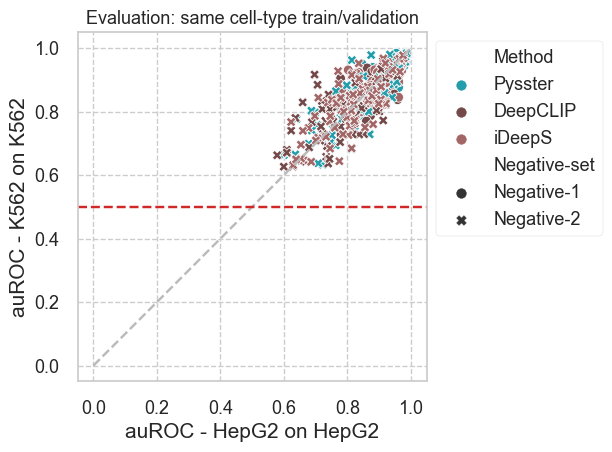

In [17]:
panel_name = "ij"

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            cross_o_merged_n1.assign(negativeset="Negative-1"),
            cross_o_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.HepG2",
    y="auroc.K562",
    hue="Method",
    style="Negative-set",
    palette=arch_colors,
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.,1.05])
# ax1.set_ylim([0.,1.05])

ax1.set_xlabel("auROC - HepG2 on HepG2")
ax1.set_ylabel("auROC - K562 on K562")

ax1.set_title("Evaluation: same cell-type train/validation")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    my_savefig(savefig_file)


plt.show()


## Cross CT performances (K562 vs HepG2)

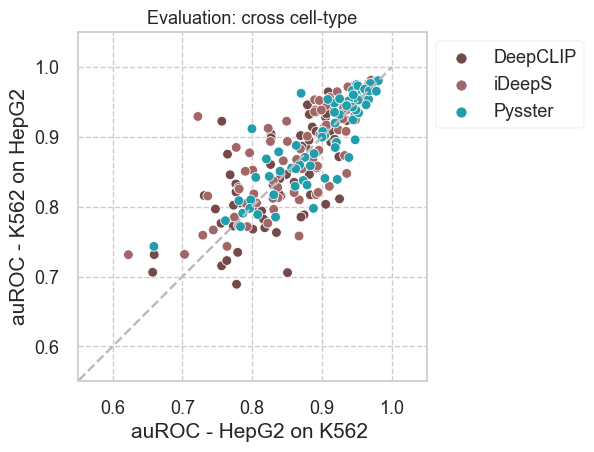

In [19]:
panel_name = "i"

if export_plots:
    savefig_file = f"plots/fig3/panel_j.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES[panel_name]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=cross_ct_merged_n1,
    x="auroc.HepG2",
    y="auroc.K562",
    hue="arch",
    palette=arch_colors,
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")

ax1.set_aspect("equal")

ax1.set_xlim([0.55, 1.05])
ax1.set_ylim([0.55, 1.05])

ax1.set_xlabel("auROC - HepG2 on K562 ")
ax1.set_ylabel("auROC - K562 on HepG2")

ax1.set_title("Evaluation: cross cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    my_savefig(savefig_file)

plt.show()


## Same CT vs cross CT

### K562 on HepG2

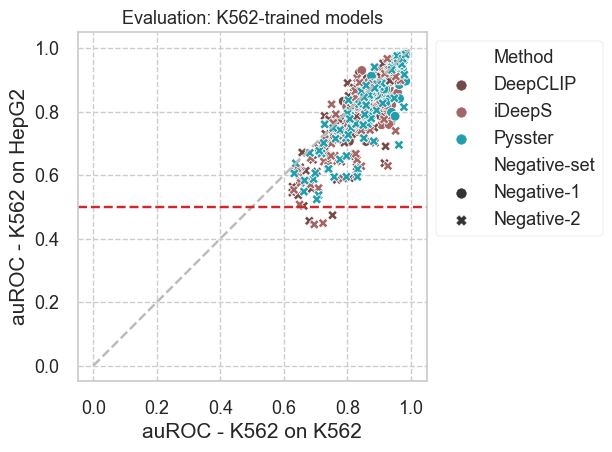

In [21]:

panel_name = "i"

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            k562_selfcross_merged_n1.assign(negativeset="Negative-1"),
            k562_selfcross_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.self",
    y="auroc.cross",
    hue="Method",
    palette=arch_colors,
    style="Negative-set",
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel("auROC - K562 on K562")
ax1.set_ylabel("auROC - K562 on HepG2")

ax1.set_title("Evaluation: K562-trained models")


# ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)


plt.show()


### HepG2 on K562

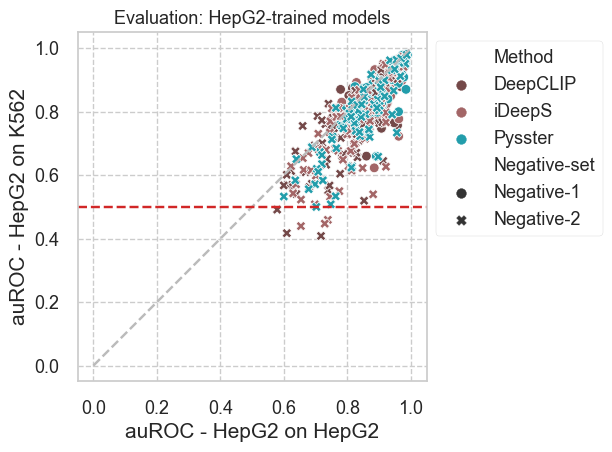

In [20]:
panel_name = "j"

if export_plots:
    savefig_file = f"plots/fig3/panel_{panel_name}.{{EXT}}"
else:
    savefig_file = None

fig = plt.figure(figsize=[v * 5 for v in FIG3_PANEL_SIZES["i"]])
ax1 = fig.add_subplot(
    1,
    1,
    1,
)

sns.scatterplot(
    data=pd.concat(
        [
            hepg2_selfcross_merged_n1.assign(negativeset="Negative-1"),
            hepg2_selfcross_merged_n2.assign(negativeset="Negative-2"),
        ]
    ).rename(columns={"arch": "Method", "negativeset": "Negative-set"}),
    x="auroc.self",
    y="auroc.cross",
    hue="Method",
    palette=arch_colors,
    style="Negative-set",
    ax=ax1,
)

plt.legend(
    bbox_to_anchor=(
        1,
        1,
    )
)


ax1.plot([0, 1], [0, 1], linestyle="--", color="#BBBBBB")
ax1.axhline(0.5, linestyle="--", color="#D12727")

ax1.set_aspect("equal")

# ax1.set_xlim([0.55,1.05])
# ax1.set_ylim([0.55,1.05])

ax1.set_xlabel("auROC - HepG2 on HepG2")
ax1.set_ylabel("auROC - HepG2 on K562")

ax1.set_title("Evaluation: HepG2-trained models")


# ax1.set_title("Evaluation: matched cell-type")

fig.subplots_adjust(left=0.20, bottom=0.15, right=0.65)


if savefig_file:
    print("Saving")
    my_savefig(savefig_file)


plt.show()
